In [1]:
import pandas as pd

# Graph Visualization 

In [24]:
merged_df = pd.read_csv("cit_ntwk_raw.csv",index_col = 0)

In [25]:
df = merged_df[['citing_paper','cited_paper','Date']]

In [26]:
df

citing_paper  \
0       dissecting mechanisms of financial crises: int...   
1                   public liquidity and financial crises   
2                               inefficient credit cycles   
3                    learning and the capital age premium   
4       investment, uncertainty, and u-shaped return v...   
...                                                   ...   
410809  kobi̇'lerin finansman sorunları ve çözüm öneri...   
410810  finanțarea întreprinderilor mici și mijlocii d...   
410811  relação entre estrutura de financiamento e açõ...   
410812                              中国商业银行综合融资能力测度及影响因素分析   
410813  коммерческий кредит и его особенности применит...   

                                              cited_paper            Date  
0                      Delayed crises and slow recoveries   February 2024  
1                      Delayed crises and slow recoveries   February 2024  
2                      Delayed crises and slow recoveries   February 2024  
3       Learning about the consumption risk exposure o...   February 2024  
4       Learning about the consumption risk exposure o...   February 2024  
...                                                   ...             ...  
410809  Financing patterns around the world: Are small...  September 2008  
410810  Financing patterns around the world: Are small...  September 2008  
410811  Financing patterns around the world: Are small...  September 2008  
410812  Financing patterns around the world: Are small...  September 2008  
410813  Financing patterns around the world: Are small...  September 2008  

[410772 rows x 3 columns]

In [27]:
# Set to collect unique nodes
unique_nodes = set(df['citing_paper']) | set(df['cited_paper'])

In [28]:
paper_nodes = pd.DataFrame(unique_nodes, columns = ['Title'])
paper_nodes['name'] = ["node"+str(i) for i in range(len(paper_nodes))]
paper_nodes

Title        name
0       Financial transaction taxes and the informatio...       node0
1       characterizing the tail-risk of factor mimicki...       node1
2       seeking the roots of entrepreneurship: insight...       node2
3       surging sovereign spreads: the impact of risin...       node3
4       melting down: systemic financial instability a...       node4
...                                                   ...         ...
186539  fatores de influência na compra de criptomoeda...  node186539
186540  impact of economic policy uncertainty on the d...  node186540
186541  auditor exits and firm performance: is there a...  node186541
186542  social media, top managers' characteristics, a...  node186542
186543  a influência do porte empresarial no retorno d...  node186543

[186544 rows x 2 columns]

In [29]:
# Mapping titles to IDs
title_to_id = paper_nodes.reset_index().set_index('Title')['index'].to_dict()

In [30]:
# Replacing titles with IDs in df1
df['citing_paper'] = df['citing_paper'].map(title_to_id)
df['cited_paper'] = df['cited_paper'].map(title_to_id)

C:\Users\ewp\AppData\Local\Temp\ipykernel_67128\687147978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['citing_paper'] = df['citing_paper'].map(title_to_id)
C:\Users\ewp\AppData\Local\Temp\ipykernel_67128\687147978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cited_paper'] = df['cited_paper'].map(title_to_id)


In [31]:
df

citing_paper  cited_paper            Date
0              43974        27533   February 2024
1             120209        27533   February 2024
2              54320        27533   February 2024
3             136323       148800   February 2024
4             153509       148800   February 2024
...              ...          ...             ...
410809         10368       132685  September 2008
410810        141965       132685  September 2008
410811         80166       132685  September 2008
410812         62411       132685  September 2008
410813         25041       132685  September 2008

[410772 rows x 3 columns]

In [32]:
edges = df[['citing_paper','cited_paper']].rename(columns = {'citing_paper':'source','cited_paper':'target'})

In [33]:
edges

source  target
0        43974   27533
1       120209   27533
2        54320   27533
3       136323  148800
4       153509  148800
...        ...     ...
410809   10368  132685
410810  141965  132685
410811   80166  132685
410812   62411  132685
410813   25041  132685

[410772 rows x 2 columns]

## DataShader Method 

reference: https://datashader.org/user_guide/Networks.html#pcap-computer-network-data

In [34]:
import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout

In [35]:
circular  = circular_layout(paper_nodes[['name']], uniform=False)
randomloc = random_layout(paper_nodes[['name']])
randomloc.tail()

name         x         y
186539  node186539  0.125416  0.950485
186540  node186540  0.652583  0.405317
186541  node186541  0.724169  0.487971
186542  node186542  0.716962  0.515436
186543  node186543  0.122925  0.713586

In [15]:
cvsopts = dict(plot_height=10000, plot_width=10000)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

In [16]:
tf.Images(nodesplot(randomloc,"Random layout"),
          nodesplot(circular, "Circular layout"))

Clearly overplotting. 

reference for overplotting: 
* https://holoviz.org/tutorial/Plotting.html
* https://datashader.org/user_guide/Plotting_Pitfalls.html

## HoloViz Method 

reference: https://examples.holoviz.org/gallery/uk_researchers/uk_researchers.html

We use HoloViz to avoid this overplotting pitfall. 

We use the circular, random, and forcedirected layout functions from DataShader since it is useful in putting our nodes into x and y coordinates. 

In [36]:
import holoviews as hv
from holoviews import opts

from colorcet import fire
from datashader.bundling import directly_connect_edges, hammer_bundle

from holoviews.operation.datashader import datashade, dynspread
from holoviews.operation import decimate

In [15]:
from dask.distributed import Client
client = Client(n_workers=5, threads_per_worker=3, memory_limit="15GB")

In [16]:
client

<Client: 'tcp://127.0.0.1:49225' processes=5 threads=15, memory=69.85 GiB>

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
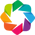

In [37]:
hv.notebook_extension('bokeh','matplotlib')

decimate.max_samples=20000
dynspread.threshold=0.01
datashade.cmap=fire[40:]
sz = dict(width=150,height=150)

opts.defaults(
    opts.RGB(width=500, height=500, xaxis=None, yaxis=None, show_grid=False, bgcolor="black"))

In [18]:
edges

source  target
0        43974   27533
1       120209   27533
2        54320   27533
3       136323  148800
4       153509  148800
...        ...     ...
410809   10368  132685
410810  141965  132685
410811   80166  132685
410812   62411  132685
410813   25041  132685

[410772 rows x 2 columns]

### 1. With random layout

In [44]:
r_nodes_df = randomloc.iloc[:,1:]
r_edges_df = edges

In [20]:
r_nodes_df

x          y
0       90.738435  78.989307
1       98.600950  61.745111
2       23.608261   7.532646
3       53.605930  99.869803
4        0.335067  55.778789
...           ...        ...
186539   6.727890  24.949561
186540   6.942172  75.416991
186541  61.194178  98.730795
186542  90.340795  20.459853
186543   6.526915  25.299983

[186544 rows x 2 columns]

In [21]:
r_edges_df

source  target
0        43974   27533
1       120209   27533
2        54320   27533
3       136323  148800
4       153509  148800
...        ...     ...
410809   10368  132685
410810  141965  132685
410811   80166  132685
410812   62411  132685
410813   25041  132685

[410772 rows x 2 columns]

In [39]:
r_nodes = hv.Points(r_nodes_df, label="Nodes")
r_edges = hv.Curve(r_edges_df, label="Edges")
len(r_nodes), len(r_edges)

(186544, 410772)

In [42]:
r_direct = hv.Curve(directly_connect_edges(r_nodes.data, r_edges.data),label="Direct")

In [43]:
dynspread(datashade(r_nodes,cmap=["cyan"])) + datashade(r_direct)

:Layout
   .DynamicMap.I  :DynamicMap   []
      :RGB   [x,y]   (R,G,B,A)
   .DynamicMap.II :DynamicMap   []
      :RGB   [x,y]   (R,G,B,A)

In [67]:
r_bundled = hv.Curve(hammer_bundle(r_nodes.data, r_edges.data),label="Bundled")

C:\Users\ewp\anaconda3\Lib\site-packages\distributed\client.py:3163: UserWarning: Sending large graph of size 23.16 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-04-17 21:03:05,249 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "C:\Users\ewp\anaconda3\Lib\site-packages\distributed\protocol\core.py", line 160, in loads
    return msgpack.loads(
           ^^^^^^^^^^^^^^
  File "C:\Users\ewp\anaconda3\Lib\site-packages\msgpack\fallback.py", line 128, in unpackb
    ret = unpacker._unpack()
          ^^^^^^^^^^^^^^^^^^
  File "C:\Users\ewp\anaconda3\Lib\site-packages\msgpack\fallback.py", line 565, in _unpack
    ret.append(self._unpack(EX_CONSTRUCT))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ewp\anaconda3\Lib\site-packages\msgpack\fallback.py", line 592, in _unpack
    ret[key] = self._unpack(EX_CONSTRUCT)
               ^^^^^^^^^^^^^^^^^^^^^^^^^

CancelledError: resample_edges-4fb8e408-0e6e-4035-91ba-7459a7646a0d

In [ ]:
dynspread(datashade(r_nodes,cmap=["cyan"])) + datashade(r_bundled)

### 2. Forcedirected

In [45]:
%time 
forcedirected = forceatlas2_layout(paper_nodes, edges)
tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))

CPU times: total: 0 ns
Wall time: 0 ns


2024-04-17 21:25:47,133 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


KeyboardInterrupt: 